# Introduction 

In the following notebook, I will creating a time series forecast aiming to predict electricity load in Spain. 

* Raw data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/01_Raw_Data)
* Cleaned data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/02_Cleaned_Data)
* Training and test data can be found [here](https://github.com/KishenSharma6/Weather-Energy-Consumption-in-Spain/tree/master/Data/03_Processed_Data)

**Read in libraries for notebook**

In [63]:
import numpy as np
import pandas as pd
from IPython.display import Image

import matplotlib.pyplot as plt
import warnings

**Set notebook preferences**

In [64]:
#Set preferences for pandas 
pd.set_option("display.max_rows", 101)

#Set style for visualizations
plt.style.use('Solarize_Light2')

#Font dictionary for plot titles and labels
font_title = {'fontsize' : 24, 
              'style':'italic',
              'fontweight' : 'semibold',
             'fontname':'Gill Sans MT'}

font_label = {'fontsize' : 16, 
              'style':'italic',
              'fontweight' : 'semibold',
             'fontname':'Gill Sans MT'}

#Set path to capture visuals from EDA
eda_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\Exploratory_Data_Analysis\Load'

#Surpress warnings
warnings.filterwarnings('ignore')

**Read in data**

In [65]:
#Set path to raw data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather/Data/03_Processed_Data'

#Read in Bilbao training and test data
train = pd.read_csv(path + '/2020_0517_load_train.csv', parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv(path + '/2020_0517_load_test.csv', parse_dates=['date_time'], index_col='date_time')

**Data preview**

*Training data*

In [66]:
#Print data shape and preview head
print('Training data shape:',train.shape)
display(train.head())

Training data shape: (28038, 5)


,load,load_forecast,load_log,load_differenced1,load_differenced2
date_time,,,,,
2015-01-02 01:00:00,24935.0,25397.0,10.124028,-0.082154,-0.041840
2015-01-02 02:00:00,23214.0,23640.0,10.052511,-0.071517,-0.001533
2015-01-02 03:00:00,22540.0,22638.0,10.023047,-0.029464,0.036348
2015-01-02 04:00:00,22096.0,22238.0,10.003152,-0.019895,0.029309
2015-01-02 05:00:00,22066.0,22299.0,10.001793,-0.001359,0.016516


*Test Data*

In [75]:
#Print data shape and preview head
print('Test data shape:',test.shape)
display(test.head())

Test data shape: (7009, 5)


,load,load_forecast,load_log,load_differenced1,load_differenced2
date_time,,,,,
2018-03-15 01:00:00,25726.0,25712.0,10.155257,-0.067156,0.004324
2018-03-15 02:00:00,24749.0,24580.0,10.116540,-0.038717,0.004225
2018-03-15 03:00:00,24393.0,24179.0,10.102051,-0.014489,0.002784
2018-03-15 04:00:00,24440.0,24086.0,10.103976,0.001925,0.003844
2018-03-15 05:00:00,24925.0,24763.0,10.123627,0.019650,-0.010543


# Raw and Deseasoned Plots

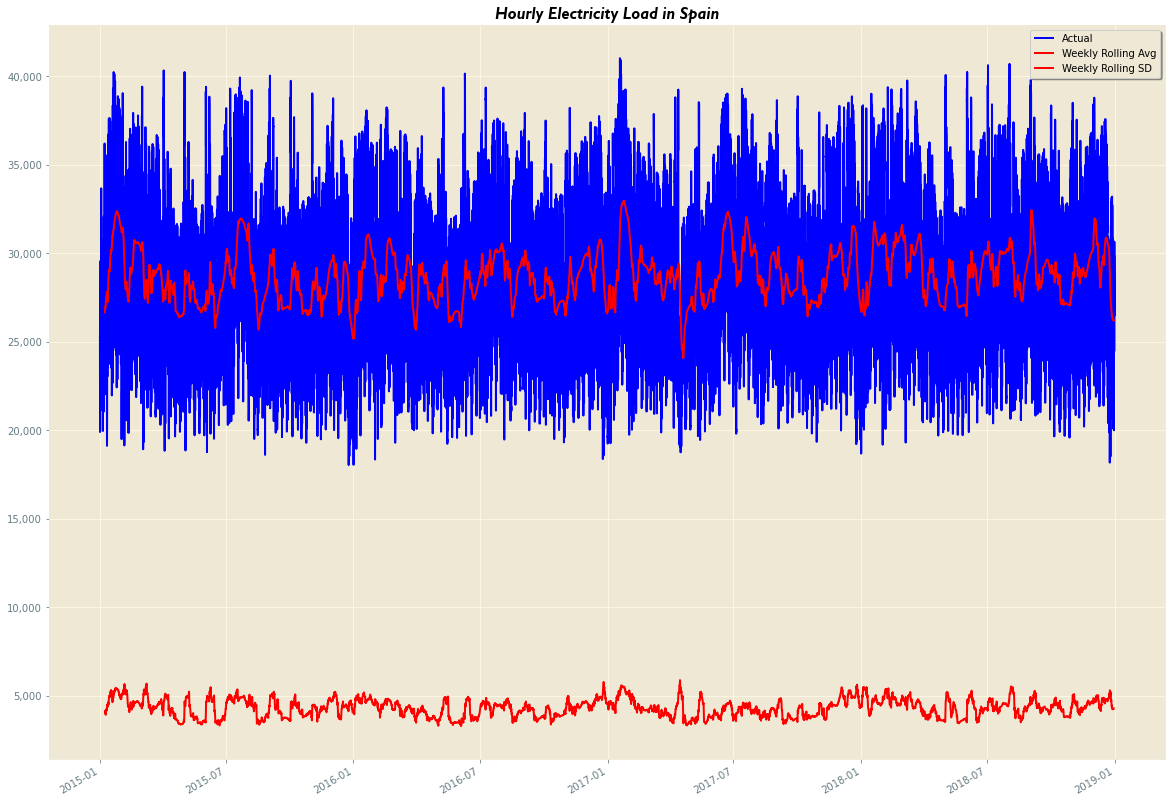

In [68]:
Image(filename = eda_path + "/Hourly_Load.png", width=900, height=700,unconfined=True)

# Include startionary data HERE!!!!!!!!!

In [69]:
#PNG of stationary data

# Quick EDA of Training and Test data 

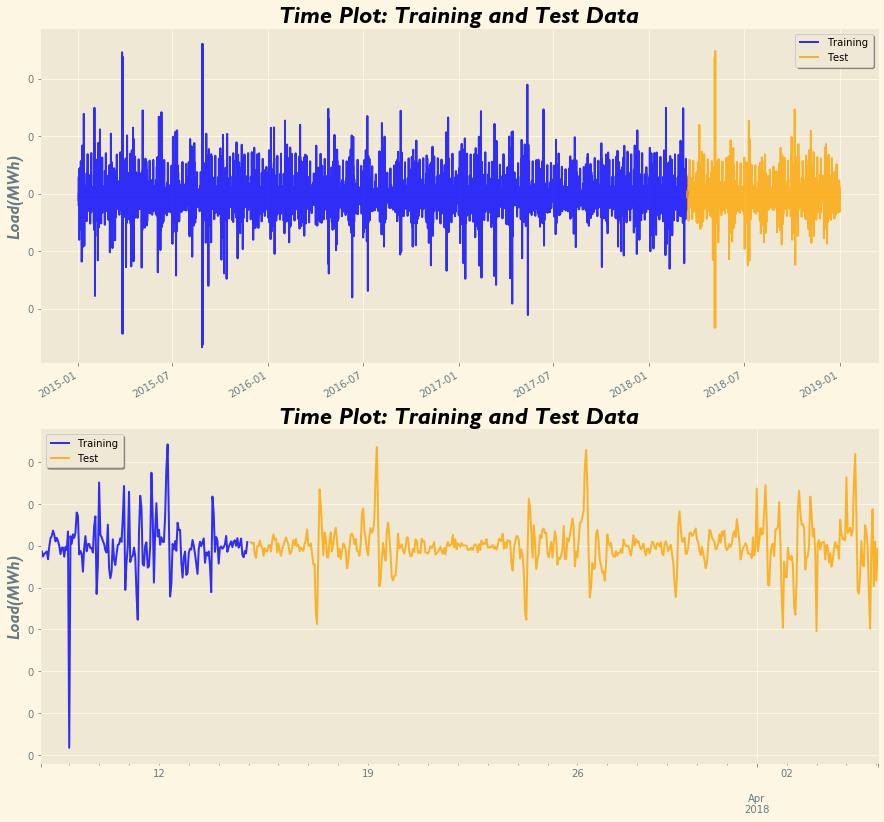

In [70]:
#Import timeseries_plot
from TimeseriesPlotter import timeseries_plot

#Set figure
f, ax = plt.subplots(2,1,figsize = (15,15))


#Plot training and test data
timeseries_plot(train.load_differenced2, color = 'blue', ax=ax[0], label = 'Training',alpha = .8)
timeseries_plot(test.load_differenced2, color = 'orange', ax = ax[0], legend = True,alpha = .8,label = 'Test', 
                title='Time Plot: Training and Test Data', title_dict=font_title,
               ylabel='Load(MWh)', label_dict=font_label)

#Plot training and test data zoomed
timeseries_plot(train.load_differenced2[-24*7:-1], color = 'blue', ax=ax[1], label = 'Training',alpha = .8)
timeseries_plot(test.load_differenced2[0:24*7*3], color = 'orange', ax = ax[1], legend = True,alpha = .8,label = 'Test', 
                title='Time Plot: Training and Test Data', title_dict=font_title,
               ylabel='Load(MWh)', label_dict=font_label)

###Set plot aesthetics###
#Axes
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))

# Forecasting 

## Base model: Single Exponential Smoothing

**Fit Naive Single Exponential Smoothing Model

In [71]:
#Import Exponential Smoothing model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Fit model to training data
es_model = ExponentialSmoothing(train['load_differenced2'].values, seasonal='add', seasonal_periods=24).fit()

#Create forecasts
predictions = es_model.forecast(len(test))

**Score model and visualize fit

In [72]:
#Import TimeSeriesStats
from TimeSeriesStats import model_performance

#Evaluate model's performance and print results
results = model_performance(predictions, test['load_differenced2'])
results

{'MAE': 0.017174760923123426,
 'MAPE': 1.0110249760643162,
 'MSE': 0.0009968776736560998,
 'RMSE': 0.03157336969118279}

In [73]:
print(predictions[:100])

[-7.68716813e-05 -2.33561649e-05 -3.62269276e-05 -6.43917867e-05
 -2.06243946e-05  7.51684093e-05  7.82651438e-05  6.75193615e-05
  7.15903142e-05  2.54754300e-05 -1.66901025e-05 -9.91404742e-05
 -5.72903739e-05 -5.76645399e-05 -3.08697354e-05  5.53420164e-06
  6.78177729e-05 -2.34902003e-06  7.98586183e-05  8.55483027e-05
  2.66215833e-05 -2.68542964e-05 -6.00938673e-05 -6.47979129e-05
 -7.68716813e-05 -2.33561649e-05 -3.62269276e-05 -6.43917867e-05
 -2.06243946e-05  7.51684093e-05  7.82651438e-05  6.75193615e-05
  7.15903142e-05  2.54754300e-05 -1.66901025e-05 -9.91404742e-05
 -5.72903739e-05 -5.76645399e-05 -3.08697354e-05  5.53420164e-06
  6.78177729e-05 -2.34902003e-06  7.98586183e-05  8.55483027e-05
  2.66215833e-05 -2.68542964e-05 -6.00938673e-05 -6.47979129e-05
 -7.68716813e-05 -2.33561649e-05 -3.62269276e-05 -6.43917867e-05
 -2.06243946e-05  7.51684093e-05  7.82651438e-05  6.75193615e-05
  7.15903142e-05  2.54754300e-05 -1.66901025e-05 -9.91404742e-05
 -5.72903739e-05 -5.76645

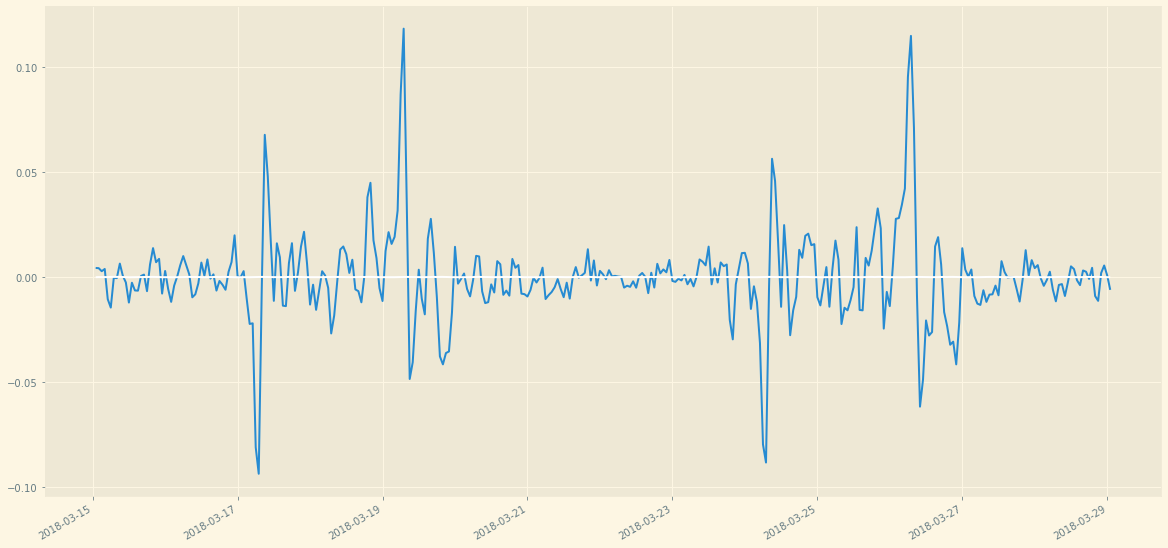

In [74]:
#Create figure
f, ax = plt.subplots(figsize = (20,10))

timeseries_plot(test['load_differenced2'][:24*7*2], ax=ax)
ax.plot(test.index[:24*7*2], predictions[:24*7*2], label = 'predictions',color = 'white' )